# Receiver Denosing Experiment

In this notebook, I aim to simulate simple communication between 1 tx and 1 rx with noise inbetween and train an AutoEncoderDecoder to denoise it.

In [1]:
import numpy as np
import tensorflow as tf

import math
from pyphysim.modulators.fundamental import BPSK, QAM, Modulator
from pyphysim.simulations import Result, SimulationResults, SimulationRunner
from pyphysim.util.conversion import dB2Linear
from pyphysim.util.misc import randn_c, count_bit_errors
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_iris
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

from scipy.fft import fft, ifft

/Users/wit/DataspellProjects/wireless_study/.wireless_env/lib/python3.8/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Simple denoising

In [2]:
def low_pass_filter(signal, cutoff_frequency, sampling_rate):
    # Fourier transform of the signal
    signal_fft = fft(signal)
    # Create a mask with True values only for frequencies lower than the cutoff
    frequency = np.linspace(0, sampling_rate, len(signal))
    mask = frequency <= cutoff_frequency
    # Apply the mask to the Fourier transformed signal
    filtered_fft = signal_fft * mask
    # Inverse Fourier transform to get the filtered signal
    filtered_signal = ifft(filtered_fft)
    return filtered_signal.real

def moving_average_filter(signal, window_size):
    cumsum_vec = np.cumsum(np.insert(signal, 0, 0))
    ma_filtered_signal = (cumsum_vec[window_size:] - cumsum_vec[:-window_size]) / window_size
    return ma_filtered_signal


In [206]:
def complex_to_mag_phase(data):
    # Calculate magnitude and phase for each complex number
    magnitude = np.abs(data)  # Magnitude
    phase = np.angle(data)    # Phase

    # Reshape the arrays and combine them
    combined = np.concatenate([magnitude.reshape(-1, 1), phase.reshape(-1, 1)], axis=1).reshape(data.shape[0], data.shape[1]*2)
    return combined

def mag_phase_to_complex(data):
    magnitude = data[:, 0]
    phase = data[:, 1]
    complex_data = magnitude * (np.cos(phase) + 1j * np.sin(phase))
    return complex_data


def complex_to_real_modified(data):
    # this will transform complex number to [real1, img1, real2, img2, etc]
    shape = data.shape
    real_part = data.real.reshape(shape[0], -1, 1)
    imag_part = data.imag.reshape(shape[0], -1, 1)
    combined = np.concatenate([real_part, imag_part], axis=2)
    return combined.reshape(shape[0], -1)

def real_to_complex_modified(data):
    # this will transform [real1, img1, real2, img2, etc] back to [complex1, complex2, ...]
    shape = data.shape
    reshaped = data.reshape(shape[0], -1, 2)
    complex_data = reshaped[:, :, 0] + 1j * reshaped[:, :, 1]
    return complex_data

def reshape_for_chunks(data, chunk_size):
    shape = data.shape
    reshaped = data.reshape((shape[0]*(shape[1]//chunk_size)), chunk_size)
    return reshaped

def reshape_back_from_chunks(data, total_samples, num_symbols):
    return data.reshape(total_samples, num_symbols)

def complex_to_real(data):
    # this case will transform complex number to [real1, real2, img1, img2]
    real_part = data.real
    imag_part = data.imag
    return np.concatenate([real_part, imag_part], axis=1)

def real_to_complex(data):
    # this case will transform real number to [real1, real2, img1, img2] -> [complex numbers]
    real_part = data[:, :data.shape[1] // 2]
    imag_part = data[:, data.shape[1] // 2:]
    return real_part + 1j * imag_part

def generate_data(modulator, noise_level, num_symbols):
    data = np.random.randint(0, modulator.M, num_symbols)
    modulated_data = modulator.modulate(data)
    noisy_data = modulated_data + noise_level * randn_c(num_symbols)
    return data, modulated_data, noisy_data


scaler = MinMaxScaler(feature_range=(-1, 1))

# Parameters
modulator = QAM(16)
noise_level = 0.2
num_symbols = 1000
chunk_size = 2 # real and img only

# Generate Datasets
training = [generate_data(modulator, noise_level, num_symbols) for _ in range(5000)]
train_unmodulated_y, training_y, training_x  = zip(*training)
train_unmodulated_y = np.array(train_unmodulated_y)
training_x = np.array(training_x)
training_y = np.array(training_y)
training_x_real = complex_to_mag_phase(training_x)
training_y_real = complex_to_mag_phase(training_y)
training_x_real_chunked = reshape_for_chunks(training_x_real, chunk_size)
training_y_real_chunked = reshape_for_chunks(training_y_real, chunk_size)
training_x_real_chunked_norm = scaler.fit_transform(training_x_real_chunked)
training_y_real_chunked_norm = scaler.transform(training_y_real_chunked)


testing = [generate_data(modulator, noise_level, num_symbols) for _ in range(2500)]
testing_unmodulated_y, testing_y, testing_x = zip(*testing)
testing_unmodulated_y = np.array(testing_unmodulated_y)
testing_x = np.array(testing_x)
testing_y = np.array(testing_y)
testing_x_real = complex_to_mag_phase(testing_x)
testing_y_real = complex_to_mag_phase(testing_y)
testing_x_real_chunked = reshape_for_chunks(testing_x_real, chunk_size)
testing_y_real_chunked = reshape_for_chunks(testing_y_real, chunk_size)
testing_x_real_chunked_norm = scaler.fit_transform(testing_x_real_chunked)
testing_y_real_chunked_norm = scaler.transform(testing_y_real_chunked)

In [186]:
from keras.models import Model
from keras.layers import Input, Dense

class CustomAutoencoder(Model):
    def __init__(self, input_shape):
        super(CustomAutoencoder, self).__init__()
        initializer = tf.keras.initializers.HeUniform(1)
        # Encoder layers
        self.encoder = tf.keras.Sequential([
            Input(shape=(input_shape,)),
            # Dense(2, activation='leaky_relu', kernel_initializer=initializer),
        ])
        # Bottleneck
        self.bottleneck = Dense(16, activation='relu', kernel_initializer=initializer)
        # Decoder layers
        self.decoder = tf.keras.Sequential([
            # Dense(2, activation='leaky_relu', kernel_initializer=initializer),
            Dense(input_shape, activation='tanh', kernel_initializer=initializer)
        ])

    def call(self, inputs, training=None, mask=None):
        # Encoder
        x = self.encoder(inputs)
        # Bottleneck
        x = self.bottleneck(x)
        # Decoder
        x = self.decoder(x)
        return x


In [211]:
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)
callbacks = [early_stopping_monitor]
# Define the autoencoder architecture
# input_signal = tf.keras.layers.Input(shape=(2 * num_symbols,))
# encoded = tf.keras.layers.Dense(128, activation='relu')(input_signal)  # Increased size
# decoded = tf.keras.layers.Dense(2 * num_symbols, activation='tanh')(encoded)  # Output size doubled
# autoencoder = tf.keras.models.Model(inputs=input_signal, outputs=decoded)
autoencoder = CustomAutoencoder(chunk_size)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005)
# Compile and train the model
autoencoder.compile(optimizer=optimizer,
                    loss='mean_absolute_error')
history = autoencoder.fit(training_x_real_chunked_norm,
                          training_y_real_chunked_norm,
                          epochs=100,
                          batch_size=256,
                          validation_split=0.2,
                          callbacks=callbacks)

Epoch 1/100
15625/15625 [==============================] - 7s 460us/step - loss: 0.0625 - val_loss: 0.0521
Epoch 2/100
15625/15625 [==============================] - 6s 394us/step - loss: 0.0495 - val_loss: 0.0451
Epoch 3/100
15625/15625 [==============================] - 6s 399us/step - loss: 0.0447 - val_loss: 0.0445
Epoch 4/100
15625/15625 [==============================] - 7s 455us/step - loss: 0.0444 - val_loss: 0.0444
Epoch 5/100
15625/15625 [==============================] - 7s 451us/step - loss: 0.0443 - val_loss: 0.0441
Epoch 6/100
15625/15625 [==============================] - 6s 413us/step - loss: 0.0441 - val_loss: 0.0440
Epoch 7/100
15625/15625 [==============================] - 6s 381us/step - loss: 0.0440 - val_loss: 0.0439
Epoch 8/100
15625/15625 [==============================] - 6s 403us/step - loss: 0.0439 - val_loss: 0.0439
Epoch 9/100
15625/15625 [==============================] - 6s 395us/step - loss: 0.0437 - val_loss: 0.0434
Epoch 10/100
15625/15625 [===========

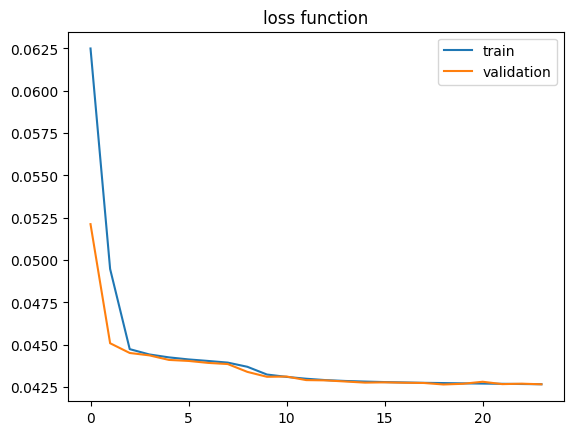

In [212]:
loss = history.history['loss']
val_loss = history.history['val_loss']

# plot losses
plt.figure()
plt.plot(loss, label='train')
plt.plot(val_loss, label='validation')
plt.title('loss function')
plt.legend()
plt.show(block=False)

In [193]:
def calculate_ber(original_data, received_data, modulator):
    demodulated_data = modulator.demodulate(received_data)
    bit_errors = count_bit_errors(original_data, demodulated_data)
    # total_bits = original_data.size * np.log2(modulator.M)
    return bit_errors

def symbol_errors(original_data, demodulated_data):
    return sum(demodulated_data != original_data)


In [213]:
# original ber
ber_ori = []
for i in range(testing_x.shape[0]):
    ber = calculate_ber(testing_unmodulated_y[i],
                        testing_x[i, :],
                        modulator)
    ber_ori.append(ber)

# ber with regular autoencoder-decoder denoiser


In [216]:
# ber with autoencoder-decoder denoiser
ber_auto = []
# pred_ys = autoencoder.predict(testing_x_real_chunked_norm)
pred_ys_imaginary = mag_phase_to_complex(scaler.inverse_transform(pred_ys)).reshape(testing_x_real.shape[0], num_symbols)
for i in range(testing_x_real.shape[0]):
    ber = calculate_ber(testing_unmodulated_y[i],
                        pred_ys_imaginary[i, :], modulator)
    ber_auto.append(ber)

In [200]:
reshape_back_from_chunks(scaler.inverse_transform(pred_ys), testing_x_real.shape[0], testing_x_real.shape[1])

array([[ 0.4461559 , -0.57427263],
       [ 0.99712086,  1.1893501 ],
       [ 0.99711186,  0.23864456],
       ...,
       [ 0.99696594, -1.2664268 ],
       [ 0.997176  ,  2.6959774 ],
       [ 0.9971222 ,  2.0604954 ]], dtype=float32)

In [217]:
print(np.mean(ber_ori), np.mean(ber_auto))

37.9608 61.6448


# Rayleigh AWGN simulation training


In [ ]:
class RayleighOrAwgnSimulatorWithDenoiser(SimulationRunner):

    def __init__(self, SINR_dB_values, simulate_with_rayleigh=False):
        # If simulate_with_rayleigh is false only AWGN is used
        super().__init__()

        self._simulate_with_rayleigh = simulate_with_rayleigh

        # Add the simulation parameters to the `params` attribute.
        self.params.add('EbN0_db', SINR_dB_values)
        self.params.set_unpack_parameter('EbN0_db')

        # Note that when M=2 BPSK modulation will be used, while other values will use QAM
        self.params.add("M", [2, 4, 16, 64, 256])
        self.params.set_unpack_parameter('M')

        # Number of times the `_run_simulation` method will run when `simulate` method is called.
        # We are using a value 100 times larger than before, but the simulation will not take
        # 100 times the previous elapsed time to finish thanks to the implementation of the
        # `_keep_going` method that will allow us to skip many of these iterations for low EbN0 values
        self.rep_max = 50000

        # Number of symbols generated for this realization
        self.num_symbols = 1000

        # Used in the implementation of `_keep_going` method. This is the maximum numbers of symbol
        # errors we allow before `_run_simulation` is stoped for a given configuration
        self.max_symbol_errors = 1. / 300. * self.num_symbols * self.rep_max

        # Set a nice message for the progressbar
        self.progressbar_message = f"Simulating for {self.params.get_num_unpacked_variations()} configurations"

        self.update_progress_function_style = "text1"  # "ipython"

    def generate_dataset(self, num_samples):
        # Since EbN0_db is an "unpacked parameter" a single value is passed to `_run_simulation`.
        # We can get the current value as below
        sinr_dB = self.params['EbN0_db']
        M = self.params['M']

        modulator = BPSK() if M == 2 else QAM(M)

        # Find the noise power from the EbN0 value (in dB)
        EbN0_linear = dB2Linear(sinr_dB)
        snr_linear = EbN0_linear * math.log2(M)
        noise_power = 1 / snr_linear
        modulated_samples = []
        noisy_modulated_samples = []
        for i in range(num_samples):
            data = np.random.randint(0, modulator.M, size=self.num_symbols)
            modulated_data = modulator.modulate(data)
            n = math.sqrt(noise_power) * randn_c(self.num_symbols)
            if self._simulate_with_rayleigh:
                # Rayleigh channel
                h = randn_c(modulated_data.size)

                # Receive the corrupted data
                received_data = h * modulated_data + n

                # Equalization
                received_data /= h

            else:
                # Receive the corrupted data
                received_data = modulated_data + n

            # Demodulate the received data and compute the number of symbol errors
            demodulated_data = modulator.demodulate(received_data)
            modulated_samples.append(modulated_data)
            noisy_modulated_samples.append(received_data)
            # symbol_errors = sum(demodulated_data != data)
            #
            # num_bit_errors = count_bit_errors(data, demodulated_data)
        return noisy_modulated_samples, modulated_samples


    def _keep_going(self, current_params, current_sim_results, current_rep):
        # Note that we have added a "symbol_errors" result in `_run_simulation` to use here

        # Get the last value in the "symbol_errors" results list, which corresponds to the current configuration
        cumulated_symbol_errors \
            = current_sim_results['symbol_errors'][-1].get_result()
        return cumulated_symbol_errors < self.max_symbol_errors


    def _run_simulation(self, current_parameters):
        # Since EbN0_db is an "unpacked parameter" a single value is passed to `_run_simulation`.
        # We can get the current value as below
        sinr_dB = current_parameters['EbN0_db']
        M = current_parameters['M']

        modulator = BPSK() if M == 2 else QAM(M)

        # Find the noise power from the EbN0 value (in dB)
        EbN0_linear = dB2Linear(sinr_dB)
        snr_linear = EbN0_linear * math.log2(M)
        noise_power = 1 / snr_linear

        # Generate random transmit data and modulate it
        data = np.random.randint(0, modulator.M, size=self.num_symbols)
        modulated_data = modulator.modulate(data)

        # Noise vector
        n = math.sqrt(noise_power) * randn_c(self.num_symbols)

        if self._simulate_with_rayleigh:
            # Rayleigh channel
            h = randn_c(modulated_data.size)

            # Receive the corrupted data
            received_data = h * modulated_data + n

            # Equalization
            received_data /= h

        else:
            # Receive the corrupted data
            received_data = modulated_data + n

        # Demodulate the received data and compute the number of symbol errors
        demodulated_data = modulator.demodulate(received_data)
        symbol_errors = sum(demodulated_data != data)

        num_bit_errors = count_bit_errors(data, demodulated_data)

        # Create a SimulationResults object and save the symbol error rate.
        # Note that the symbol error rate is given by the number of symbol errors divided by the number of
        # transmited symbols. We want to combine the symbol error rate for the many calls of `_run_simulation`.
        # Thus, we choose `Result.RATIOTYPE` as the "update_type". See the documentation of the `Result` class
        # for more about it.
        simResults = SimulationResults()
        simResults.add_new_result("symbol_error_rate",
                                  Result.RATIOTYPE,
                                  value=symbol_errors,
                                  total=self.num_symbols)
        simResults.add_new_result("symbol_errors",
                                  Result.SUMTYPE,
                                  value=symbol_errors)
        simResults.add_new_result("num_bit_errors",
                                  Result.SUMTYPE,
                                  value=num_bit_errors)
        simResults.add_new_result("bit_error_rate",
                                  Result.RATIOTYPE,
                                  value=num_bit_errors,
                                  total=int(np.log2(modulator.M)) * data.size)
        return simResults

In [ ]:
EbN0_db_awgn = np.linspace(-5, 30, 8)

runner_awgn = RayleighOrAwgnSimulatorWithDenoiser(EbN0_db_awgn,
                                                  simulate_with_rayleigh=False)
runner_awgn.set_results_filename("qam_awgn")
print("Simulation parameters:", runner_awgn.params)

# runner_awgn.simulate_in_parallel()
runner_awgn.simulate()
print(runner_awgn.elapsed_time)